In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 122kB 7.7MB/s 
     |████████████████████████████████| 952kB 11.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65164 sha256=f074d73203cf546bf497e8b6e6e3582660945e660de62851b04fa7fd17e6e362
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 57.8MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstallin

In [189]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import torch
import torchvision
from PIL import Image
import time
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [190]:
DIR_INPUT = '/content/drive/MyDrive/Colab_Notebooks/Ptyxiaki/LeafsDetectionRaw'
DIR_TEST = f'{DIR_INPUT}/test'
# Loading the device now
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [220]:
# HELPER FUNCTIONS FOR VIZUALISING / PREDICTING

def get_boxes(tensor,index,score=0.5):

    if index >= len(tensor)  or index<0:
        return 0
    
    temp_boxes = []
    for i in range(len(tensor[index]['boxes'])):
        if tensor[index]['scores'][i] > score:
            temp_boxes.append(tensor[index]['boxes'][i].cpu().detach().numpy().astype(np.int32))    
        
    return temp_boxes    




def load_test_dataset():
    data_path = DIR_TEST
    test_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(num_output_channels=1),
            torchvision.transforms.ToTensor(),]
    ))
    
    test_loader = torch.utils.data.DataLoader(    
        test_dataset,
        batch_size=1,
        num_workers=1,
        shuffle=False
    )
    return test_loader

def get_test_image(imageName,imageFullPath,imageCropListForSave,itr,score = 0.5):
    image, targets= next(itr)
    sample = image
    
    image = image.to(device)
    model.eval()
    outputs = model(image)
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]   
    boxes = get_boxes(outputs,0,score)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    #print(sample.shape)
    img = sample[0].permute(1,2,0).cpu().numpy()
    #print(img.shape)
        
    img = np.array(img)
    img = np.reshape(img,(img.shape[1],img.shape[1]))
    print(img.shape)
    imageCropId = 0
    for box in boxes:
        x,y,w,h = box
        imageCropId = imageCropId + 1
      
        cv2.rectangle(np.float32(img),(int(box[0]), int(box[1])),(int(box[2]), int(box[3])),0, 2)

        im=Image.open(imageFullPath)
        im=im.crop(box)
        print(box)

        imageCropName= imageCropListForSave+ str(imageCropId)+"_" + imageName
        #im = im.save(imageCropName) 
    #ax.set_axis_off()
    ax.imshow(img,cmap='gray')


**Loading Model**

In [211]:
model = torch.load("/content/drive/MyDrive/Colab_Notebooks/Ptyxiaki/leaves_fasterrcnn_model.pth", map_location={'cuda:0': 'cpu'})
model.to(device)
print("Model loaded")

Model loaded


**Validation**

(1024, 1024)
[  3  34 500 794]
[272  34 977 556]
(1024, 1024)
[ 548  154 1002  409]
[391 510 744 877]
[251 306 718 858]


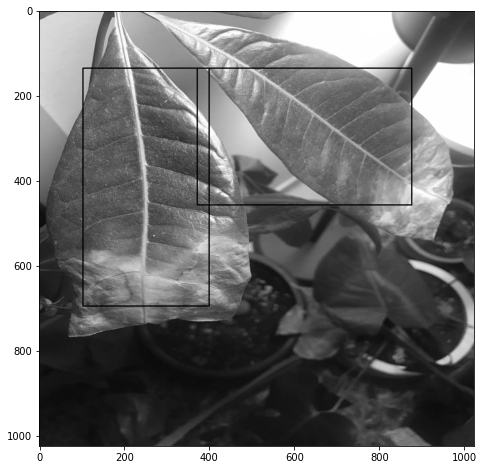

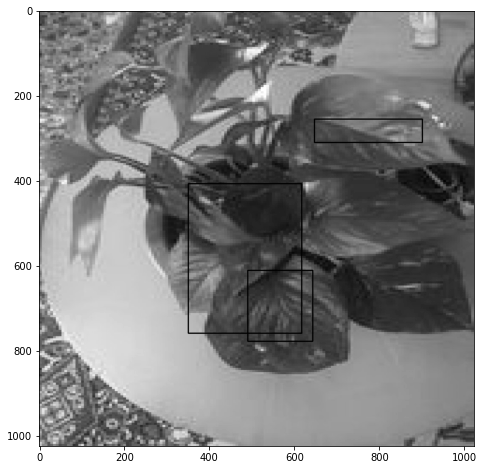

In [221]:
it = iter(load_test_dataset())
imageCropListForSave = "/content/drive/MyDrive/Colab_Notebooks/Ptyxiaki/croppedImages/"
image_list = DIR_TEST+"/leaf"
for path in os.listdir(image_list):
    imageFullPath = os.path.join(image_list, path)
    if os.path.isfile(imageFullPath):
        imageName=imageFullPath.split("/")[-1]
        #print(imageName)
        #print (imageFullPath)
        get_test_image(imageName,imageFullPath,imageCropListForSave,it,0.5)